In [1]:
!pip install accelerate==0.34.2
!pip install spacy
!python -m spacy download en

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 6.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 12.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.4.1
    Uninstalling safetensors-0.4.1:
      Successfully uninstalled safetensors-0.4.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.2
    Uninstalling huggingface-hub-0.20.2:
      Successfully uninstalled huggingface-hub-0.20.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 89.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.8/204.8 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/1

In [11]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import re


with open('dataset.json', 'r', encoding="utf-8") as file:
    data = json.load(file)

with open('new_test_dataset.json', 'r', encoding="utf-8") as file:
    t_data = json.load(file)

def shorten_article(entry):
    entry["article"] = entry["article"][:int(len(entry["article"])*0.2)]
    cleaned_text = re.sub(r'\b(Donald|donald|Trump|trump|former|Former|president|President|Joe|joe|Biden|biden|J.)\b', '', entry["article"])
    entry["article"] = cleaned_text.strip()
    return entry

#data = [shorten_article(entry) for entry in data]

df = pd.DataFrame(data)
#print(df)
#df = df.sample(frac=0.5,random_state=42)

tdf = pd.DataFrame(t_data)

label_mapping = {"left": 0, "lean-left": 1, "lean-right": 2, "right": 3}
df["label"] = df['label'].map(label_mapping)
tdf["label"] = tdf['label'].map(label_mapping)

train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['article'], df['label'], test_size=0.3, stratify=df['label'], random_state=30)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify = temp_labels, random_state=30)

t_texts = tdf["article"]
t_labels = tdf["label"]
print(len(t_texts))

1796


/opt/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Acce

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.329906,0.887770,0.887318,0.889240,0.887770
2,0.479900,0.225779,0.923261,0.923182,0.925415,0.923261
3,0.479900,0.277462,0.930456,0.930362,0.931261,0.930456


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Evaluation Results: {'eval_loss': 0.27746179699897766, 'eval_accuracy': 0.9304556354916067, 'eval_f1': 0.9303623467449238, 'eval_precision': 0.9312605953756883, 'eval_recall': 0.9304556354916067, 'eval_runtime': 21.1872, 'eval_samples_per_second': 98.409, 'eval_steps_per_second': 3.115, 'epoch': 3.0}
Testing the model...
Test Results: {'eval_loss': 0.24588635563850403, 'eval_accuracy': 0.9348034515819751, 'eval_f1': 0.9346401126372007, 'eval_precision': 0.9357256250445435, 'eval_recall': 0.9348034515819751, 'eval_runtime': 20.9891, 'eval_samples_per_second': 99.385, 'eval_steps_per_second': 3.144, 'epoch': 3.0}
Generating confusion matrix...


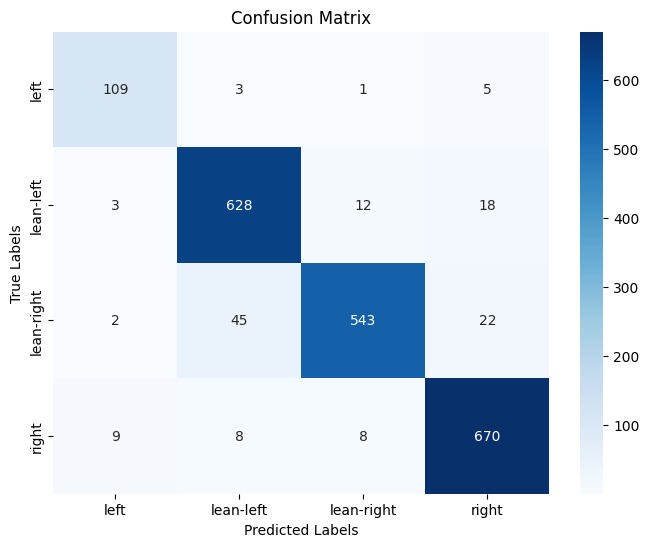

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification

device = torch.device("cuda")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def tokenize_function(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, 128)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, 128)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, 128)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)
new_test_dataset = TextClassificationDataset(t_texts, t_labels, tokenizer, 128)
new_test_dataloader = DataLoader(new_test_dataset, batch_size=16)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model.to(device)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    report_to=[]
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

print("Testing the model...")
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

print("Generating confusion matrix...")
raw_preds = trainer.predict(test_dataset)
preds = raw_preds.predictions.argmax(-1)
conf_matrix = confusion_matrix(test_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Evaluating on the new test dataset...")
new_test_results = trainer.evaluate(new_test_dataset)
print("New Test Results:", new_test_results)

print("Generating confusion matrix...")
raw_preds = trainer.predict(new_test_dataset)
preds = raw_preds.predictions.argmax(-1)
conf_matrix = confusion_matrix(t_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for New Test Dataset')
plt.show()

Evaluating on the new test dataset...


In [ ]:
import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

model.eval()

def classify_sentences(text, model, tokenizer):
    sentences = [sent.text for sent in nlp(text).sents]
    inputs = tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = probs.argmax(dim=-1).tolist()
    scores = probs.max(dim=-1).values.tolist()
    return list(zip(sentences, labels, scores))

all_sentence_results = []
for article in tqdm(df["article"], desc="Processing Articles", unit="article"):
    try:
        all_sentence_results.extend(classify_sentences(article, model, tokenizer))
    except:
        continue

sentence_df = pd.DataFrame(all_sentence_results, columns=["Sentence", "Predicted Label", "Score"])

pd.set_option("display.max_colwidth", None)


Processing Articles:   2%|▏         | 147/6952 [00:13<09:26, 12.00article/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f0f19366710>>
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Processing Articles:   5%|▍         | 339/6952 [00:30<07:07, 15.48article/s]

In [ ]:
top_n = 15
for label, group in sentence_df.groupby("Predicted Label"):
    sorted_group = group.sort_values(by="Score", ascending=False).head(top_n)
    print(f"\nLabel {label}:")
    print(sorted_group[["Sentence", "Score"]].to_string(index=False))


Label 0:
                                                                                                                                                                                                                                                                                           Sentence    Score
                                                                                                                                                                                                                                      But Haley’s sturdy pronouncements belie a certain wobbliness. 0.999008
                                                                                                                                                                                                                                     But there was also a real crispness to the speech’s arguments. 0.999005
                                                                                       

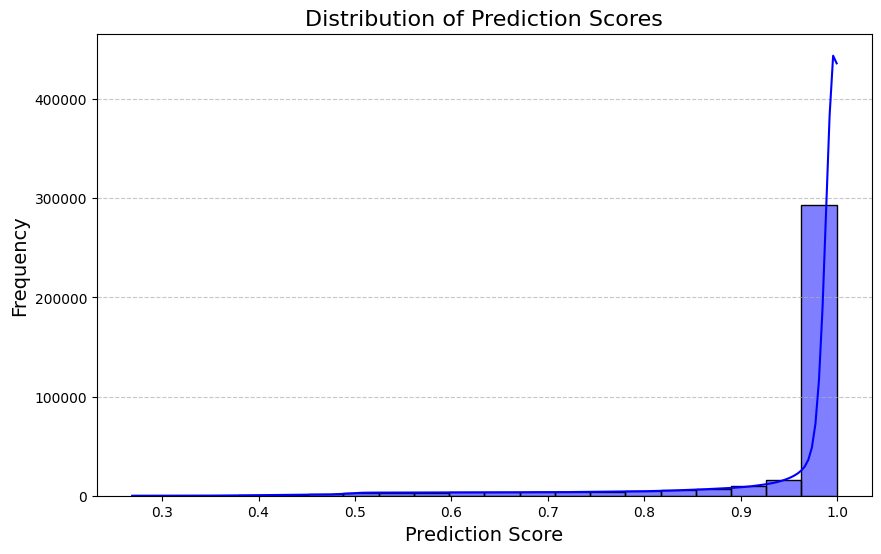

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(sentence_df["Score"], bins=20, kde=True, color="blue")

plt.xlabel("Prediction Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Prediction Scores", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

/opt/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/lib/python3.10/site-packages/accelerate/acceler

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.259948,0.929976,0.930498,0.932060,0.929976
2,0.357500,0.179434,0.944844,0.944884,0.947259,0.944844
3,0.357500,0.165530,0.955875,0.955818,0.955865,0.955875


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Evaluation Results: {'eval_loss': 0.16552965342998505, 'eval_accuracy': 0.9558752997601918, 'eval_f1': 0.9558184848078799, 'eval_precision': 0.9558650561176741, 'eval_recall': 0.9558752997601918, 'eval_runtime': 8.9746, 'eval_samples_per_second': 232.322, 'eval_steps_per_second': 7.354, 'epoch': 3.0}
Testing the model...
Test Results: {'eval_loss': 0.13466118276119232, 'eval_accuracy': 0.9645254074784276, 'eval_f1': 0.9645011147463962, 'eval_precision': 0.9646843532327154, 'eval_recall': 0.9645254074784276, 'eval_runtime': 9.1906, 'eval_samples_per_second': 226.971, 'eval_steps_per_second': 7.181, 'epoch': 3.0}
Generating confusion matrix...


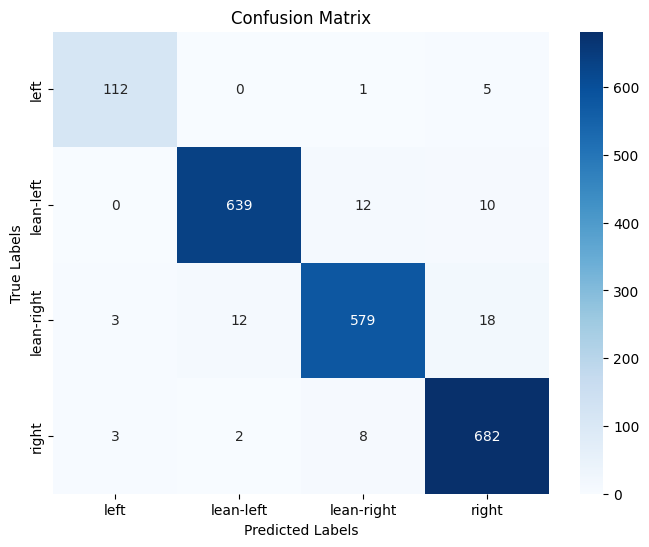

In [ ]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification

device = torch.device("cuda")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def tokenize_function(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, 128)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, 128)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, 128)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)


model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

print("Testing the model...")
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

print("Generating confusion matrix...")
raw_preds = trainer.predict(test_dataset)
preds = raw_preds.predictions.argmax(-1)
conf_matrix = confusion_matrix(test_labels, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()